In [41]:
from galfind import (
    Instrument,
    Photometry,
    Photometry_rest,
    config,
    useful_funcs_austind,
    Euclid, Spitzer, CFHT, Subaru,
    NISP,
    MegaCam,
    HSC,
    VIS,
    IRAC,
    Multiple_Filter,
    SED_obs,
)

from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Row

Setup filters - do it in stages to avoid confusion over filter names.

In [4]:
filterset_mc = Multiple_Filter.from_instrument('MegaCam', excl_bands=['CFHT/MegaCam.g',
                                                                      'CFHT/MegaCam.r', 
                                                                      'CFHT/MegaCam.i', 
                                                                      'CFHT/MegaCam.z', 
                                                                      'CFHT/MegaCam.Y', 
                                                                      'CFHT/MegaCam.J', 
                                                                      'CFHT/MegaCam.gri',
                                                                      'CFHT/MegaCam.H'])    

filterset_hsc = Multiple_Filter.from_instrument('HSC')

filterset = Multiple_Filter.from_instruments(['NISP', 'VIS', 'IRAC'], excl_bands=['Spitzer/IRAC.I3', 'Spitzer/IRAC.I4'])
filterset = filterset + filterset_mc + filterset_hsc       

In [5]:
depths = [26] + [28] * len(filterset.band_names[1:])
depths = np.array(depths) * u.ABmag


<Magnitude [26., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.] mag(AB)>

Plot transmission 

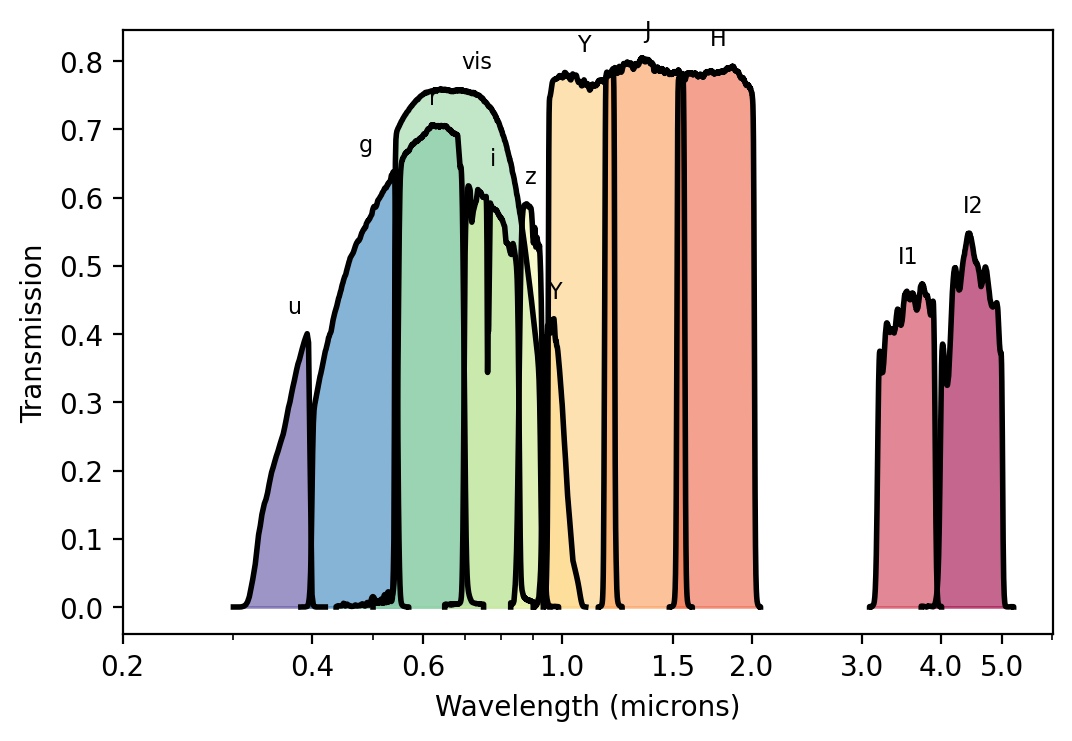

In [6]:
fig, ax = plt.subplots(dpi=200)
filterset.plot(ax=ax)
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel('Transmission')   
ax.set_xscale('log')
ax.set_xticks([0.2, 0.4, 0.6, 1, 1.5, 2, 3, 4, 5])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
plt.show()

Process spectra and save photometry

In [42]:
folder = '/raid/scratch/data/JAGUAR/Full_Spectra'
out_folder = '/nvme/scratch/work/tharvey/catalogs/' 

r = 1 # realisation
redshift_bins = [(0.2, 1), (1, 1.5), (1.5, 2), (2, 3), (3, 4), (4, 5), (5, 15)]
filenames = [f'{folder}/JADES_SF_mock_r{r}_v1.2_spec_5A_30um_z_{str(z1).replace(".", "p")}_{str(z2).replace(".", "p")}.fits' for z1, z2 in redshift_bins]

out_filename = f'{out_folder}/JADES_SF_mock_r{r}_v1.2_{filterset.instrument_name}_phot.fits'
out_colnames = [f'{filter.instrument_name}_{filter.band_name}_fnu' for filter in filterset.filters]
out_colnames=['ID', 'redshift'] + out_colnames

save_counter = 0
rows = []
for file in filenames:
    hdu = fits.open(file)
    wav = hdu[2].data # Angstrom
    table = hdu[3].data
    ids = table['id']
    redshifts = table['redshift']
    
    nrows = hdu[1].shape[0]
   
    for i in tqdm(range(nrows), desc=f'Processing spectra from {file}'):
        flux = hdu[1].section[i, :] / (1+redshifts[i]) # convert from rest-frame to observed-frame
        sed = SED_obs(redshifts[i], wav, flux, wav_units=u.AA, mag_units=u.erg/u.s/u.cm**2/u.AA)
        mock_phot = sed.create_mock_phot(filterset=filterset, min_flux_pc_err=0)
        flux = mock_phot.flux.to(u.nJy)
        row = [ids[i], redshifts[i]] + list(flux.value)
        rows.append(row)
        
    output_table = Table(rows, names=out_colnames)
    output_table.write(out_filename, format='fits', overwrite=True)
        


Processing spectra from /raid/scratch/data/JAGUAR/Full_Spectra/JADES_SF_mock_r1_v1.2_spec_5A_30um_z_0p2_1.fits:   0%|          | 0/44829 [00:00<?, ?it/s]


TypeError: Row.__init__() got an unexpected keyword argument 'names'

open file to check it

In [37]:
table = Table.read(out_filename)

In [38]:
table

id,redshift,MegaCam_u_fnu,HSC_g_fnu,HSC_r_fnu,VIS_vis_fnu,HSC_i_fnu,HSC_z_fnu,HSC_Y_fnu,NISP_Y_fnu,NISP_J_fnu,NISP_H_fnu,IRAC_I1_fnu,IRAC_I2_fnu
,,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy
int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,0.200103,8.650908,15.277812,16.323843,17.289469,16.537947,17.007984,16.874409,16.699287,15.57056,14.855826,6.421755,5.233176
2,0.200144,22.487715,38.099255,41.876198,44.712025,43.017178,44.785534,44.97753,44.983418,42.82042,41.18375,17.440845,13.773311
3,0.200162,55.52977,90.23368,93.255424,96.99236,90.96201,93.37219,93.30844,92.97376,86.47964,83.14011,37.229424,30.920446
4,0.200219,20.34609,33.687443,34.919914,35.945183,33.481358,33.74915,33.178535,32.62517,29.61287,28.204693,12.901312,11.045859
5,0.200321,29.840385,49.97763,50.304337,52.15701,48.962982,48.9993,47.595867,46.19871,41.80003,39.464554,21.482279,21.760658
6,0.200344,35.41891,48.067368,48.405117,45.64819,38.751976,37.213943,36.223015,35.669697,30.301682,29.219435,13.64498,13.133728
7,0.200381,55.384132,89.997025,93.01084,96.737976,90.72344,93.12731,93.06372,92.72993,86.25283,82.92206,37.131783,30.839352
8,0.2004,40.82747,64.46527,63.77307,65.17154,60.02389,61.010445,60.85625,60.50624,55.262108,52.870647,24.152098,20.658314
